In [55]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud , STOPWORDS
from PIL import Image
import os
import plotly.graph_objs as go

In [4]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# Text Preprocessing

In [7]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    pattern = re.compile('\W')
    porter = PorterStemmer()
    
    if type(x) == type(''):
        x = re.sub(pattern , ' ' , x)
    
        x = porter.stem(x)
        example = BeautifulSoup(x)
        x = example.get_text()
    
    return x

In [40]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

In [41]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/df['']
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [42]:
df = extract_features(df)

token features...
fuzzy features..


In [43]:
#df.to_csv('nlp_features_train.csv')

# Analysis of extracted features

In [44]:
df_duplicate = df[df['is_duplicate'] ==1 ]
dfp_non_duplicate = df[df['is_duplicate']==0 ]

#converting 2d array of q1 and q2 into 1d array by flattening
p = np.dstack([df_duplicate['question1'] , df_duplicate['question2']]).flatten()
n = np.dstack([dfp_non_duplicate['question1'] , dfp_non_duplicate['question2']]).flatten()

print('Number of data points in duplicate pairs' , len(p))
print('Number of data points in non_duplicate_pairs' , len(n))

#Saving the np array into a text file
#np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
#np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in duplicate pairs 298526
Number of data points in non_duplicate_pairs 510054


In [45]:
textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add('said')
stopwords.add('br')
stopwords.add(" ")
stopwords.remove('not')
stopwords.remove('like')

print('total number of words in duplicate pair questions : ' , len(textp_w))
print('total number of words in non_duplicate pair questions : ' , len(textn_w))

total number of words in duplicate pair questions :  16109886
total number of words in non_duplicate pair questions :  33193130


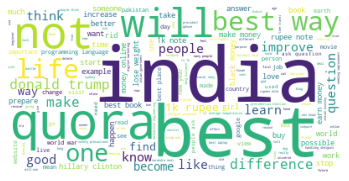

In [46]:
wc = WordCloud(background_color = 'white' , max_words = len(textp_w) , stopwords = stopwords)
wc.generate(textp_w)
plt.imshow(wc)
plt.axis('off')
plt.show()

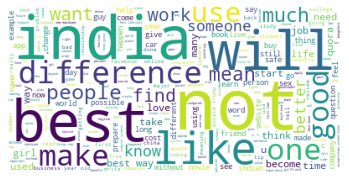

In [47]:
wc = WordCloud(background_color = 'white' , max_words = len(textn_w) , stopwords = stopwords)
wc.generate(textn_w)
plt.imshow(wc)
plt.axis('off')
plt.show()

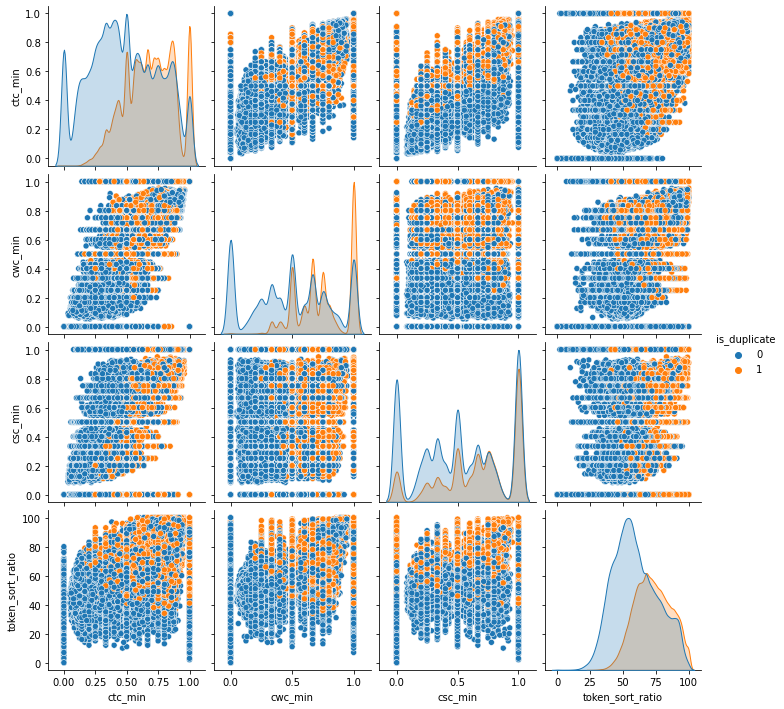

In [48]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 
                 'cwc_min', 
                 'csc_min', 
                 'token_sort_ratio', 
                 'is_duplicate']][0:n], 
             hue='is_duplicate', 
             vars=['ctc_min', 
                   'cwc_min', 
                   'csc_min', 
                   'token_sort_ratio'])
plt.show()

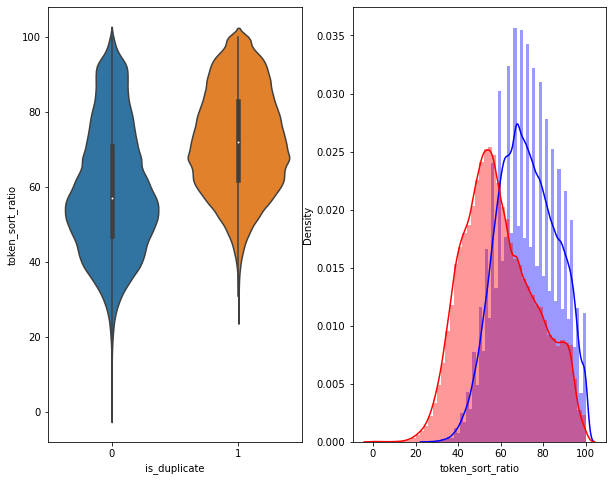

In [49]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'token_sort_ratio' , data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] ==1.0]['token_sort_ratio'][0:] , label = '1' , color = 'blue')
sns.distplot(df[df['is_duplicate']==0.0]['token_sort_ratio'][0:] , label = '0' , color = 'red')
plt.show()

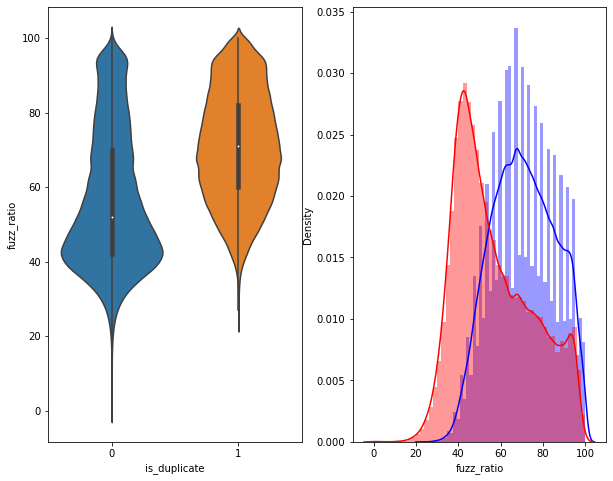

In [50]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'fuzz_ratio' , data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['fuzz_ratio'][0:] , label = '1' , color = 'blue')
sns.distplot(df[df['is_duplicate']==0.0]['fuzz_ratio'][0:] , label = '0' , color = 'red')
plt.show()

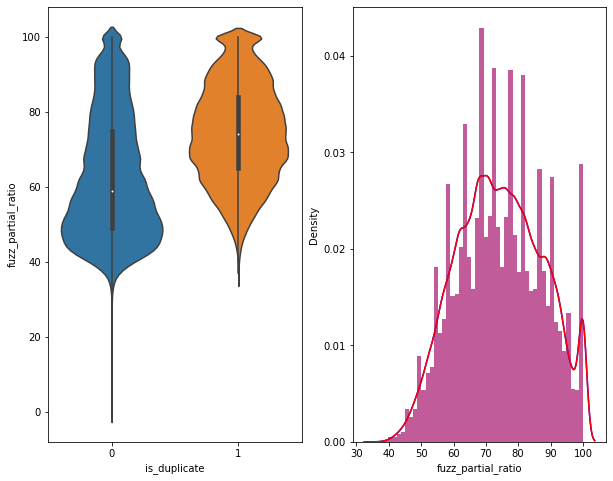

In [51]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'fuzz_partial_ratio' , data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['fuzz_partial_ratio'][0:] , label = '1' , color = 'blue')
sns.distplot(df[df['is_duplicate']==1.0]['fuzz_partial_ratio'][0:] , label = '0' , color = 'red')
plt.show()

# Visualization

In [53]:
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [54]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2 , verbose = 2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.403s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116438
[t-SNE] Computed conditional probabilities in 0.154s
[t-SNE] Iteration 50: error = 82.5597916, gradient norm = 0.0533732 (50 iterations in 1.284s)
[t-SNE] Iteration 100: error = 70.6714935, gradient norm = 0.0099081 (50 iterations in 0.976s)
[t-SNE] Iteration 150: error = 68.5777206, gradient norm = 0.0054476 (50 iterations in 0.839s)
[t-SNE] Iteration 200: error = 67.7174225, gradient norm = 0.0041607 (50 iterations in 0.742s)
[t-SNE] Iteration 250: error = 67.2251663, gradient norm = 0.0036801

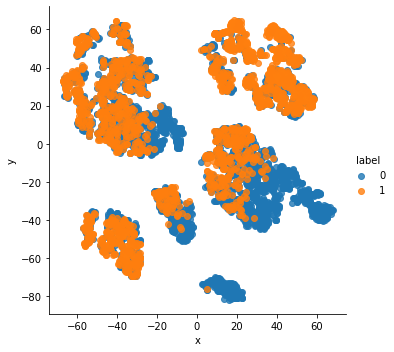

In [65]:
df = pd.DataFrame({'x' : tsne[:,0] , 'y' : tsne[:,1] , 'label' : y})
sns.lmplot(data = df , x = 'x' , y = 'y' , hue = 'label' , fit_reg = False)
plt.show()

In [66]:
from sklearn.manifold import TSNE
tsne3d = TSNE(n_components = 3 , verbose = 2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.423s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116438
[t-SNE] Computed conditional probabilities in 0.154s
[t-SNE] Iteration 50: error = 81.4755402, gradient norm = 0.0345555 (50 iterations in 2.440s)
[t-SNE] Iteration 100: error = 69.0582275, gradient norm = 0.0031931 (50 iterations in 1.403s)
[t-SNE] Iteration 150: error = 67.5737228, gradient norm = 0.0016801 (50 iterations in 1.224s)
[t-SNE] Iteration 200: error = 67.0193176, gradient norm = 0.0011157 (50 iterations in 1.219s)
[t-SNE] Iteration 250: error = 66.7030106, gradient norm = 0.0009153

In [75]:
trace1 = go.Scatter3d(x = tsne3d[:,0],
                     y = tsne3d[:,1],
                     z = tsne3d[:,2],
                      marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    ))

In [76]:
import plotly.offline as py

In [77]:
data = trace1
fig = dict(data = data)
py.iplot(fig)